# Intro

This notebook provides minimal functionality for applying DMD to noisy climate data. 

The following capabilities are implemented:

* use mask to remove land pixels from training
* window average (window before current time)
* densely sample weekly means around local mins of total ice
* model monthly across years


In [1]:
%load_ext autoreload
%autoreload 2
import dill

import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD, FbDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing import hankel_preprocessing

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.ndimage import gaussian_filter

from tqdm.autonotebook import tqdm, trange

from scipy.signal import fftconvolve

import sys

sys.path.insert(0, '../src/WeatherDMD/')

from WeatherDMD.plot_jupyter import contour_compare, contour_data
from WeatherDMD.data_wrangle import get_days_before, get_test_set, window_mean
from WeatherDMD.dmd_routines import reshape_data2dmd, train_dmd, reshape_Psi2data, eval_dmd

import xarray as xr

from WeatherDMD import data_pipeline
from copy import deepcopy

/var/folders/3p/bn7y7hcd6s7_28j4tq3cv2hr0000gs/T/ipykernel_93852/1476540381.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# DATA

In [2]:
dSet = data_pipeline.load_data("2020-01-01_2020-02-27_era5_slice_resampled.zarr")  

In [3]:
dSet

<xarray.Dataset>
Dimensions:              (time: 232, level: 1, latitude: 361, longitude: 720)
Coordinates:
  * latitude             (latitude) float32 90.0 89.5 89.0 ... -89.0 -89.5 -90.0
  * level                (level) int64 1000
  * longitude            (longitude) float32 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-02-27T18:0...
Data variables:
    geopotential         (time, level, latitude, longitude) float32 dask.array<chunksize=(29, 1, 91, 180), meta=np.ndarray>
    temperature          (time, level, latitude, longitude) float32 dask.array<chunksize=(29, 1, 91, 180), meta=np.ndarray>
    u_component_of_wind  (time, level, latitude, longitude) float32 dask.array<chunksize=(29, 1, 91, 180), meta=np.ndarray>

In [4]:
# calculate the unique delta time in hours
delta_time = np.unique(np.diff(dSet.time))
delta_time_hrs = delta_time/np.timedelta64(1, 'h')
delta_time_hrs = delta_time_hrs[0]
print(f"The unique delta time is {delta_time_hrs} hours")

The unique delta time is 6.0 hours


In [5]:
# currently the number of points in lat and lon need to be the same for this pipeline to work
 
data, attrs, coords, dims = data_pipeline.dataset_to_array(
    dSet, variable="temperature", lat_slice=slice(90, -90), lon_slice=slice(90, 270) 
)

In [6]:
data.shape

(232, 361, 361)

In [7]:
coords

{'latitude': <xarray.DataArray 'latitude' (latitude: 361)>
 array([ 90. ,  89.5,  89. , ..., -89. , -89.5, -90. ], dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
     level     int64 1000
 Attributes:
     long_name:  latitude
     units:      degrees_north,
 'level': <xarray.DataArray 'level' ()>
 array(1000)
 Coordinates:
     level    int64 1000,
 'longitude': <xarray.DataArray 'longitude' (longitude: 361)>
 array([ 90. ,  90.5,  91. , ..., 269. , 269.5, 270. ], dtype=float32)
 Coordinates:
     level      int64 1000
   * longitude  (longitude) float32 90.0 90.5 91.0 91.5 ... 269.0 269.5 270.0
 Attributes:
     long_name:  longitude
     units:      degrees_east,
 'time': <xarray.DataArray 'time' (time: 232)>
 array(['2020-01-01T00:00:00.000000000', '2020-01-01T06:00:00.000000000',
        '2020-01-01T12:00:00.000000000', ..., '2020-02-27T06:00:00.000000000',
        '2020-02-27T12:00:00.000000000', '2020-02-27T18:00:00

In [8]:
DATA = np.array(data)[None, ...]

In [9]:
DATA.shape

(1, 232, 361, 361)

In [10]:
contour_data(data)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=231), IntSlider(value=180, description='f…

In [11]:
x = np.linspace(0, 1, data.shape[2])
y = np.linspace(0, 1, data.shape[1])

In [12]:
# compute the integral of the field along the x and y axis (across space)
Integral_eval = np.trapz(np.trapz(data, x, axis = 2), y, axis = 1)

Text(0, 0.5, 'Integral of the field')

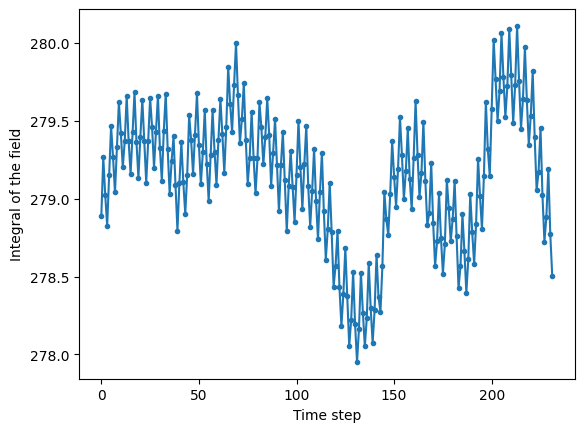

In [13]:
fig, ax = plt.subplots()
plt.plot(Integral_eval, '.-')
plt.xlabel('Time step')
plt.ylabel('Integral of the field')

## Train optimised DMD

DMD does not really require batching the data in the deep-AI sense. We simply need to select a training interval and fit DMD. After fitting, DMD model with fitted parameters can be used for prediction on any time interval. 

1. Identify a starting point in time by `year`, `day` 
2. Identify, how many days to train on: `T_train`
3. Select subset of `DATA`, based on the above. Perform window-averaging to de-noise it. 
4. Fit DMD. 
5. Compute DMD predictions from `year`, `day` forward. 

In [14]:
DATA[0].shape

(232, 361, 361)

In [15]:
len(DATA)

1

In [16]:
# get training data
year = 0
day = 150

window = 10
T_train = 100

X0_ = get_days_before(DATA, year, day, T_train+window-1)
X0_.shape

(109, 361, 361)

In [17]:
(X0_ == data[day-T_train-window+1:day, :, :]).all()

True

In [18]:
timestamps = coords["time"][day-T_train-window+1:day]
len(timestamps)

109

In [19]:
# compute windowed mean. Returns T_train snapshots before current time point (not inclusive)
X0, timestamps_windowed = window_mean(X0_, window = window, t = timestamps)
X0_.shape, X0.shape, timestamps_windowed.shape

((109, 361, 361), (100, 361, 361), (100,))

In [20]:
contour_compare(X0_[window-1:], X0)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=99), IntSlider(value=180, description='f_…

In [21]:
rank = 3
t = np.arange(-T_train, 0)

# time delay and dmd snapshots
X_delayed, t_delayed, data_shape = reshape_data2dmd(X0, t, time_delay = 2, 
                                                     mask = None,
                                                    isKeepFirstTimes = True)
# train dmd
Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, rank = rank)

Psi = reshape_Psi2data(Psi_, data_shape, mask = None)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/DMD/.venv/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 394736.13794685574. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/DMD/.venv/lib/python3.11/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [22]:
Psi.shape

(3, 361, 361)

In [23]:
T_train + window - 1

109

In [24]:
t = np.arange(-T_train, T_train)
# extend the windowed timestamps to include the future
timestamps_windowed = np.concatenate((timestamps_windowed, timestamps_windowed.values[-1] + np.arange(1, T_train+1)*delta_time))
# true_after = get_test_set(DATA, year, day, window, T_train + window -1)
true_after = get_test_set(DATA, year, day, window, T_train)
X_true = np.concatenate((X0, true_after), axis = 0)

X_eval = eval_dmd(Lambda, Psi, bn, t)

In [25]:
# make X_true and X_eval the same number of time points
if X_true.shape[0] > X_eval.shape[0]:
    X_true = X_true[:X_eval.shape[0], :, :]
elif X_true.shape[0] < X_eval.shape[0]:
    X_eval = X_eval[:X_true.shape[0], :, :]
    t = t[:X_true.shape[0]]
    timestamps_windowed = timestamps_windowed[:X_true.shape[0]]

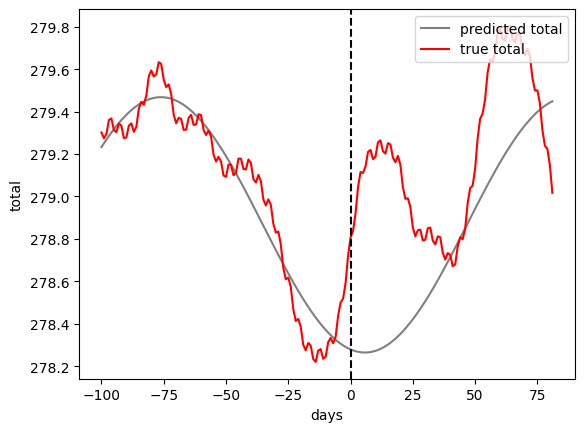

In [26]:
# COMPUTE METRIC OF PREDICTION
# compute the integral of the field along the x and y axis (across space)
Integral_eval = np.trapz(np.trapz(X_eval, x, axis = 2), y, axis = 1)
Integral_true = np.trapz(np.trapz(X_true, x, axis = 2), y, axis = 1)

plt.plot(t, Integral_eval.T, color = 'grey', label = 'predicted total')
plt.plot(t, Integral_true, label = 'true total', color = 'r')
plt.axvline(0, linestyle = '--', color = 'k')

plt.ylabel('total')
plt.xlabel('days')

plt.legend(loc = 'upper right')

In [27]:
contour_compare(X_true, X_eval)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=181), IntSlider(value=180, description='f…

In [28]:
rmse = np.linalg.norm(X_true - X_eval, axis = (1, 2)) / (X_true.shape[1] * X_true.shape[2])

In [29]:
rmse.shape

(182,)

Text(0, 0.5, 'RMSE (%)')

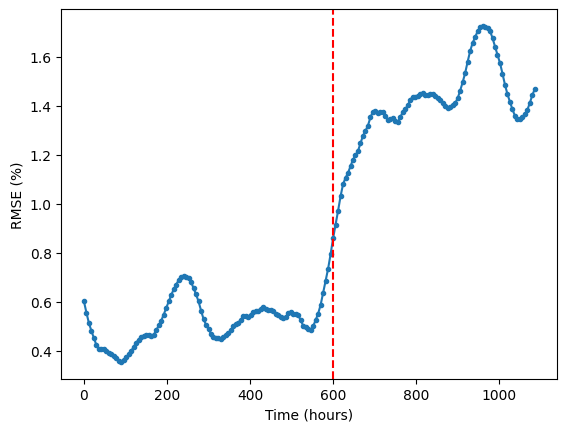

In [30]:
time_vector = np.arange(0, len(rmse))*delta_time_hrs
plt.plot(time_vector, rmse*100, '.-')
# add a vertical line at the time when the prediction starts
plt.axvline(T_train*delta_time_hrs, linestyle = '--', color = 'r')
plt.xlabel('Time (hours)')
plt.ylabel('RMSE (%)')

In [31]:
X_fitted = X_eval[:T_train, :, :]
timestamps_fitted = timestamps_windowed[:T_train]
X_pred = X_eval[T_train:, :, :]
timestamps_pred = timestamps_windowed[T_train:]

In [32]:
coords_pred = deepcopy(coords)
coords_pred["time"] = timestamps_pred

In [33]:
X_pred = data_pipeline.array_to_dataarray(X_pred, attrs, coords_pred, dims)

In [34]:
X_pred

<xarray.DataArray (time: 82, latitude: 361, longitude: 361)>
array([[[244.26966233, 244.26966234, 244.26966234, ..., 244.26966234,
         244.26966234, 244.26966234],
        [245.07169701, 245.07263956, 245.07380254, ..., 243.33955801,
         243.33788927, 243.3358152 ],
        [245.84132238, 245.84160558, 245.84222083, ..., 242.54263245,
         242.53915641, 242.53599632],
        ...,
        [261.78464001, 261.75996381, 261.73494857, ..., 259.95091976,
         259.9377764 , 259.92489288],
        [260.90845112, 260.89546419, 260.88236828, ..., 259.80234199,
         259.80100009, 259.79970519],
        [260.07261998, 260.07261998, 260.07261998, ..., 260.07261998,
         260.07261998, 260.07261998]],

       [[244.30073581, 244.30073582, 244.30073582, ..., 244.30073582,
         244.30073582, 244.30073582],
        [245.10486259, 245.10583048, 245.10701921, ..., 243.36985143,
         243.36811027, 243.36595155],
        [245.87597275, 245.87624401, 245.87685229, ..., 242.57187604,
         242.56827129, 242.56500238],
...
        [265.85249477, 265.83894785, 265.82571193, ..., 264.26382198,
         264.25885524, 264.25382677],
        [265.24307365, 265.23647832, 265.22998042, ..., 264.27359579,
         264.27404304, 264.27445648],
        [264.5809315 , 264.5809315 , 264.5809315 , ..., 264.5809315 ,
         264.5809315 , 264.5809315 ]],

       [[248.19673649, 248.1967365 , 248.1967365 , ..., 248.1967365 ,
         248.1967365 , 248.1967365 ],
        [248.42270701, 248.42326733, 248.42359171, ..., 247.94939441,
         247.94893471, 247.94848547],
        [248.6859502 , 248.68523546, 248.68436437, ..., 247.74290032,
         247.74297926, 247.74334941],
        ...,
        [265.75076057, 265.73746105, 265.72450101, ..., 264.19474108,
         264.18958366, 264.18437236],
        [265.1537591 , 265.14716402, 265.14067939, ..., 264.20297391,
         264.20339892, 264.20378476],
        [264.50512928, 264.50512928, 264.50512928, ..., 264.50512928,
         264.50512928, 264.50512928]]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
    level      int64 1000
  * longitude  (longitude) float32 90.0 90.5 91.0 91.5 ... 269.0 269.5 270.0
  * time       (time) datetime64[ns] 2020-02-07T12:00:00 ... 2020-02-27T18:00:00
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

In [35]:
coords_fitted = deepcopy(coords)
coords_fitted["time"] = timestamps_fitted
X_fitted = data_pipeline.array_to_dataarray(X_fitted, attrs, coords_fitted, dims)

In [36]:
X_fitted

<xarray.DataArray (time: 100, latitude: 361, longitude: 361)>
array([[[248.21389225, 248.21389226, 248.21389226, ..., 248.21389226,
         248.21389226, 248.21389226],
        [248.54323567, 248.54424582, 248.5450822 , ..., 247.87109176,
         247.86933183, 247.8673372 ],
        [248.89170672, 248.89092334, 248.89012205, ..., 247.576073  ,
         247.57367024, 247.57187836],
        ...,
        [266.97574317, 266.95737176, 266.93881876, ..., 264.87215121,
         264.86923481, 264.86617072],
        [266.15319238, 266.14595694, 266.13860271, ..., 264.88930758,
         264.88991091, 264.89056874],
        [265.27077337, 265.27077337, 265.27077337, ..., 265.27077337,
         265.27077337, 265.27077337]],

       [[248.23759603, 248.23759604, 248.23759604, ..., 248.23759604,
         248.23759604, 248.23759604],
        [248.55820122, 248.55918662, 248.55999232, ..., 247.90380773,
         247.90211996, 247.90021227],
        [248.89927129, 248.89848508, 248.89767103, ..., 247.61687931,
         247.61462209, 247.6129597 ],
...
        [261.57889004, 261.55470235, 261.5302322 , ..., 259.81033559,
         259.79680627, 259.78355269],
        [260.72738916, 260.71439913, 260.70132604, ..., 259.65858683,
         259.65719943, 259.65584839],
        [259.91848371, 259.91848371, 259.91848371, ..., 259.91848371,
         259.91848371, 259.91848371]],

       [[244.24146048, 244.24146049, 244.24146049, ..., 244.24146049,
         244.24146049, 244.24146049],
        [245.04097749, 245.04189441, 245.04303101, ..., 243.3126395 ,
         243.31104412, 243.30905594],
        [245.80874424, 245.80903864, 245.80965977, ..., 242.51719924,
         242.51385461, 242.510806  ],
        ...,
        [261.68026276, 261.65582673, 261.63107971, ..., 259.87903659,
         259.86569723, 259.85262578],
        [260.81632019, 260.80332935, 260.79024242, ..., 259.72881496,
         259.72744964, 259.72612604],
        [259.99388852, 259.99388852, 259.99388852, ..., 259.99388852,
         259.99388852, 259.99388852]]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
    level      int64 1000
  * longitude  (longitude) float32 90.0 90.5 91.0 91.5 ... 269.0 269.5 270.0
  * time       (time) datetime64[ns] 2020-01-13T12:00:00 ... 2020-02-07T06:00:00
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

In [ ]:
data_pipeline.datarray_to_zarr(X_pred)
data_pipeline.datarray_to_zarr(X_fitted, "era5_dmd_fit")